In [1]:
%load_ext autoreload
%autoreload 2
from NewtonOptimizer import NewtonOptimizer
import sys
sys.path.append('/Users/lindseyschweitzer/Documents/GitHub/lfschweitzer.github.io/')

from posts.post5.logistic import LogisticRegression, GradientDescentOptimizer

# <u> Newton’s Method for Logistic Regression </u>

![](newton.jpg)

This blog post includes implementing Newton's Method for Logistic Regression and performing 3 experiments.


These three experiments include:

1. When alpha is chosen appropriately, Newton’s method converges to the correct choice of w.

2. Under at least some circumstances, Newton’s method can converge much faster than standard gradient descent, in the sense of decreasing the empirical risk.

3. If alpha is too large, Newton’s method fails to converge.

Then finally, I was able to analyze the convergence time for standard gradient descent as opposed to newton's method. I was able to conclude that, especially when p becomes very large, Newton's method takes significantly more time. Though my these three experiments and my analysis I was able to see how Newton's method can be a helpful method in minimizing empirical risk, but only under specific circumstances: when p and alpha are not too large.

## Data Generation

Before doing any experiments, I had to generate data for a classification problem.

In [2]:
import torch

def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

Plot the data

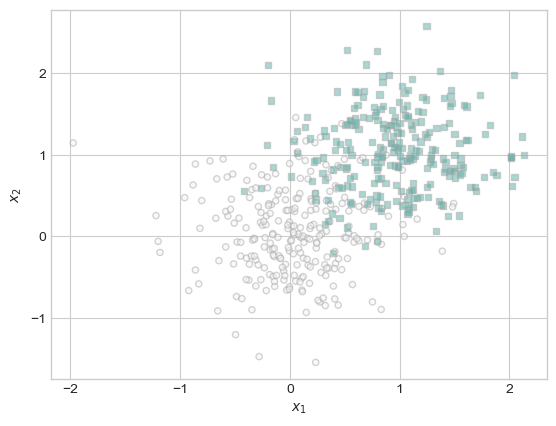

In [3]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

def plot_classification_data(X, y, ax):
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")
    
    
fig, ax = plt.subplots(1, 1)

X, y = classification_data(n_points= 500, noise= 0.5, p_dims= 2)
plot_classification_data(X, y, ax)

Code to graph a straight line

In [4]:
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

## 1. When alpha is chosen appropriately, Newton’s method converges to the correct choice of w.

In [5]:
# initialize a Logistic Regression 
LR = LogisticRegression() 
opt = NewtonOptimizer(LR)

# initialize for main loop
loss_vec = []

for index in range(5000):
    
    opt.step(X, y, alpha = 0.5)
    
    loss = LR.loss(X, y).item()
    loss_vec.append(loss)

In [6]:
def find_accuracy(X, y):

    predictions = LR.predict(X)
    correct_preds = (predictions == y).float()
    accuracy = torch.mean(correct_preds)

    print(f"Accuracy: {accuracy.item()}")

find_accuracy(X, y)

Accuracy: 0.8980000019073486


[(-1.0, 2.0), (-1.0, 2.0)]

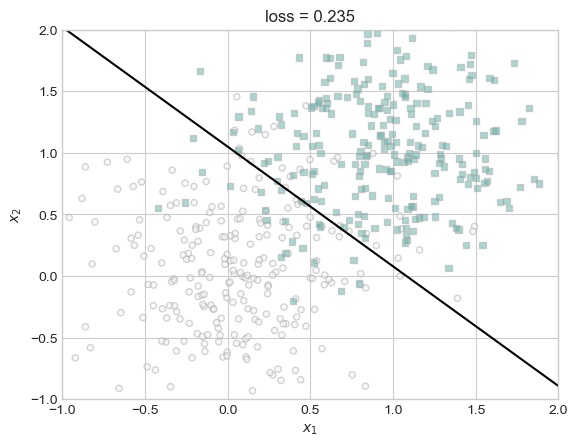

In [7]:
fig, ax = plt.subplots(1, 1)

plot_classification_data(X, y, ax)

draw_line(LR.w, x_min=-1, x_max=2, ax=ax, color="black")
ax.set_title(f"loss = {loss:.3f}")
ax.set(xlim=(-1, 2), ylim=(-1, 2))

Plot the loss over time over the 2000 iterations.

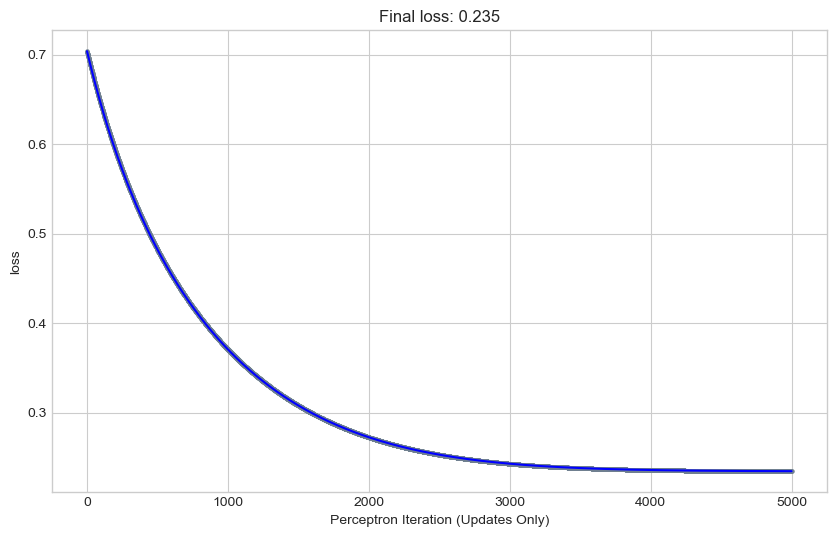

In [8]:
import numpy as np

def plot_loss(loss, label= ""):
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(10, 6))

    
    plt.plot(loss, color = "blue", label=label)
    plt.scatter(torch.arange(len(loss)), loss, color = "slategrey", s=5)
    plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")
    
    plt.title(f"Final loss: {loss[len(loss)-1]:.3f}")

plot_loss(loss_vec)

From these visualizations, we can see that the weights chosen lead to high accuracy rates and a line that is pretty good at separating the data. We can also see that the loss converges over time.

## 2. Under at least some circumstances, Newton’s method can converge much faster than standard gradient descent, in the sense of decreasing the empirical risk.

First lets do standard gradient descent so we can compare it to Newton's method later.

In [15]:
LR_Stand = LogisticRegression() 
opt = GradientDescentOptimizer(LR_Stand)

# initialize for main loop
loss_vec_stand = []

for index in range(2000):
    
    # for vanilla gradient descent, alpha must be sufficiently small and beta must be 0
    opt.step(X, y, alpha = 0.5, beta = 0)
    loss = LR_Stand.loss(X, y).item()
    loss_vec_stand.append(loss)

In [10]:
find_accuracy(X, y)

Accuracy: 0.8980000019073486


Now, lets show do Newton's method to compare the decrease in empirical risk.

In [11]:
# Use the same data as before

# initialize a Logistic Regression and use Newton Optimizer
LR_Newt = LogisticRegression() 
opt = NewtonOptimizer(LR_Newt)

loss_vec_newt = []

for index in range(2000):
    
    opt.step(X, y, alpha = 50)
    
    loss = LR_Newt.loss(X, y).item()
    loss_vec_newt.append(loss)

In [12]:
find_accuracy(X, y)

Accuracy: 0.8980000019073486


Now let's compare the decrease in empirical risk:

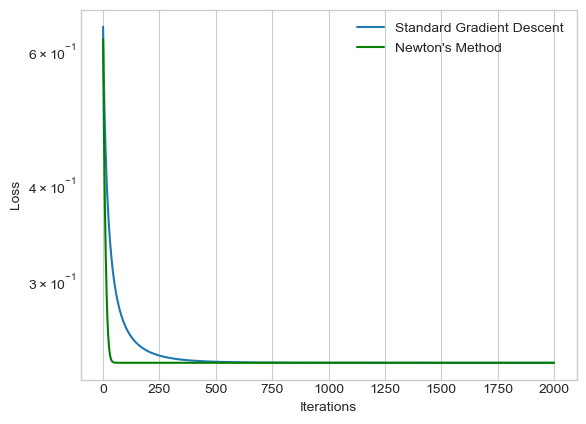

In [18]:
plt.plot(loss_vec_stand, label='Standard Gradient Descent')
plt.plot(loss_vec_newt, color='green', label="Newton's Method")


# use log y axis
plt.semilogy()
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

Here we can see that Newton's method converges at a much faster rate than Standard Gradient Descent with the same data and learning rate.

## 3. If alpha is too large, Newton’s method fails to converge.

In [14]:
# initialize a Logistic Regression and Newton Optimizer
LR = LogisticRegression() 
opt = NewtonOptimizer(LR)

# initialize for main loop
loss_vec_alpha = []

for index in range(200):
    
    opt.step(X, y, alpha = 1010)
    
    loss = LR.loss(X, y).item()
    loss_vec_alpha.append(loss)

_LinAlgError: linalg.inv: The diagonal element 1 is zero, the inversion could not be completed because the input matrix is singular.

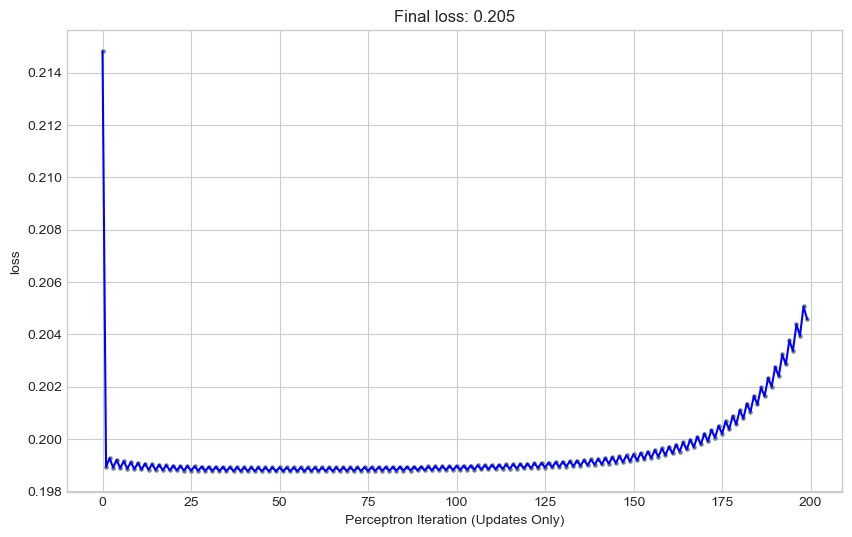

In [ ]:
plot_loss(loss_vec_alpha)

With a high learning rate, we can see that Newton's method does not cause empirical risk to converge, but instead after some time it begins to increase!

## Operation Counting

The goal is to answer these two questions:

1. Does Standard Gradient Descent or Newton's method require less computational units?
2. And, when p becomes very large, does it ever pay off to use Newton's Method?

To answer these questions we make this set of assumptions that methods have these computational costs:

* Computing loss   --> c
* Computing grad   --> 2c
* Computing H      --> pc
* Inverting pxp    --> $k_1p^\gamma$ where $2 \leq \gamma <3$
* Multiplying by H --> $k_2p^{2}$

To make a singular step for <b> Newton's Method: </b>


1. Compute loss: c
2. For $t_\mathrm{nm}$ steps:

    a. Compute grad: $2c$

    b. Compute H : $pc$

    c. Invert H: $k_1p^\gamma$

    d. Multiply by H: $k_2p^{2}$

Total time: $$O(c + t_\mathrm{nm} * (2c + pc + k_1p^\gamma + k_2p^{2}))$$

To make a singular step for <b> Standard Gradient Descent: </b>

1. Compute loss: $c$
2. For $t_\mathrm{gd}$ steps:

    a. Compute grad: $2c$

Total time: $$O(c + t_\mathrm{gd} * 2c)$$

If $$O(GD) = c + t_\mathrm{gd} * 2c$$ and $$O(NM) = c + t_\mathrm{nm} * (2c + pc + k_1p^\gamma + k_2p^{2})$$ then 
$$\frac{t_\mathrm{nm}}{t_\mathrm{gd}} = \frac{2c + pc + k_1p^\gamma + k_2p^{2}}{2c}$$

This critical ratio determines the relative computational cost between Newton's method and Standard Gradient Descent as $p$ increases. It can be simplified to 
$$1 + \frac{p}{2} + \frac{k_1p^\gamma}{2c} +  \frac{k_2p^{2}}{2c}$$ 

Therefore as $p$ shows larger, the critical ratio, and thereby the relative computational expense of Newton's method and Standard Gradient Descent grows polynomially, determined by $$k_1p^\gamma + k_2p^{2}$$ In contrast, the computational cost of Standard Gradient does not depend on $p$.


## Conclusion

Creating this blog post allowed me to understand the implementation and specific applications of Newton's method. I was able to visualize how it is able to converge, even at a faster rate than Standard Gradient Descent under certain circumstances. However, I was also able to understand the circumstances in which Newton's method fails. If alpha is too large Newton's method will fail to converge. Additionally, Newton's method has a much higher time complexity which can become significant when p is large.

Through the experience of implementing this blog post, I was able to understand how different machine learning methods could be applied depending on the specifics of the data to be trained on. With large amounts of data, like many machine learning problems today, Newton's method might be too large to compute. Overall, I was able to learn more about Machine learning models and how to apply them to different data.